# Winds pre-processing:

Take last non nan value for wind pressure levels.

In [1]:
# run script that installs missing libraries
! chmod 755 ../scripts.sh
! ../scripts.sh

  Using cached google_cloud_storage-2.2.1-py2.py3-none-any.whl (107 kB)
  Using cached google_cloud_storage-2.2.0-py2.py3-none-any.whl (107 kB)


In [2]:
import os
from matplotlib import pyplot as plt
import matplotlib.path as mpath
import numpy as np
import pandas as pd
import xarray as xr
import cartopy
import cf_units
from datetime import datetime
from datetime import timedelta
import rasterio
import cartopy.crs as ccrs
import gcsfs
from tqdm import tqdm
import pyproj
from pyproj import Transformer
from google.cloud import storage
from re import search
from os import listdir
from os.path import isfile, join
from scipy import ndimage

from process_pangeo import *
from GC_scripts import *
from processRCM import *
from reprojectionFunctions import *
import multiprocessing as mp

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# Google cloud
PROJECT = 'ee-iceshelf-gee4geo'
BUCKET = "ee-downscalingclimatemodels"

os.environ["GCLOUD_PROJECT"] = PROJECT
storage_client = storage.Client()
bucket = storage_client.bucket(BUCKET)

In [4]:
VAR = 'VVP'
pathGC, fileGC = pathToFiles(VAR, date1='19800101', date2='19801231')
downloadFileFromGC(pathGC, '', fileGC)
#vvp = ProcesasRCMVar(VAR, xr.open_dataset(fileGC))
f0 = xr.open_dataset(fileGC)
f0 = resampleMonthlyMean(BasicPreprocRCM(ProcessRCMVar(VAR, f0)))
os.remove(fileGC)
f0

<xarray.Dataset>
Dimensions:      (time: 12, PLEV: 7, y: 148, x: 176)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-31 1980-02-29 ... 1980-12-31
  * x            (x) float32 -3.01e+06 -2.975e+06 ... 3.08e+06 3.115e+06
  * y            (y) float32 -2.555e+06 -2.52e+06 ... 2.555e+06 2.59e+06
  * PLEV         (PLEV) float32 200.0 500.0 600.0 700.0 800.0 850.0 925.0
    spatial_ref  int64 0
Data variables:
    VVP          (time, PLEV, y, x) float32 20.15 19.62 19.07 ... -10.28 -10.4
Attributes: (12/21)
    CDI:                            Climate Data Interface version 1.9.7.1 (h...
    Conventions:                    CF-1.6
    history:                        Mon Mar  7 11:51:03 2022: ncap2 -O -s VVP...
    institute:                      University of Liege (Belgium)
    contact:                        ckittel@uliege.be
    NCO:                            netCDF Operators version 4.8.1 (Homepage ...
    ...                             ...
    frequency:                      day
    institute_id:                   ULg
    institution:                    University of Liege - Belgium
    model_id:                       ULg-MAR311
    product:                        output
    reference:                      http://www.climato.be

In [5]:
nbmonths = f0.dims['time']
x = f0.dims['x']
y = f0.dims['y']

f0shape = (x,y)

nb_vars = len(list(f0.data_vars))
var_list = list(f0.data_vars)

DATASET = np.asarray(f0[VAR].values)

print(f'Number of variables: {nb_vars}')
print(f'Variables: {var_list}')
print(f'Original shape: {DATASET.shape}')   

vvp=np.transpose(DATASET,[0,2, 1, 3])
print(f'Shape after transposing: {vvp.shape}')   

Number of variables: 1
Variables: ['VVP']
Original shape: (12, 7, 148, 176)
Shape after transposing: (12, 148, 7, 176)


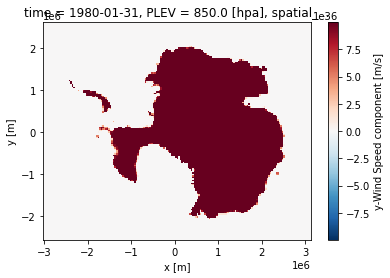

In [6]:
f0.isel(time=0, PLEV = 5).VVP.plot(x='x')

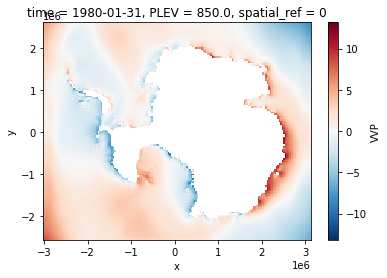

In [7]:
# Replace missing values with NaN
f0 = xr.where(f0[VAR]<90, f0, np.nan)
f0.isel(time=0, PLEV = 5).VVP.plot(x='x')

In [8]:
def findLastNonNanTime(time0, f0, VAR):
    a = np.empty((f0.dims['y'],f0.dims['x'])) # shape (y,x)
    ynumb = 0

    for y0 in f0.y.values:
        d = pd.DataFrame(f0.sel(time=time0, y=y0)[VAR].values)
        # calculate last valid index across dataframe
        idx = d.apply(pd.Series.last_valid_index)
        a[ynumb,:] = idx.values        
        ynumb+=1
        
    return a

CPU times: user 805 ms, sys: 18.7 ms, total: 823 ms
Wall time: 798 ms


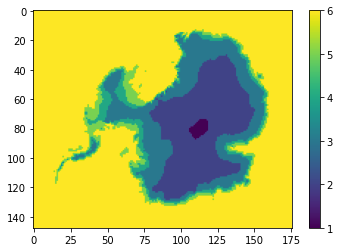

In [11]:
%%time 
time0 = f0.time[0].values # time-step
a = findLastNonNanTime(time0, f0, VAR)
plt.imshow(a)
plt.colorbar()

In [33]:
%%time
d = f0.isel(time = 0)
mask = xr.DataArray(a.astype(int), dims = ["y_", "x_"])
mask

CPU times: user 1.29 ms, sys: 0 ns, total: 1.29 ms
Wall time: 1.21 ms


<xarray.DataArray (y_: 148, x_: 176)>
array([[6, 6, 6, ..., 6, 6, 6],
       [6, 6, 6, ..., 6, 6, 6],
       [6, 6, 6, ..., 6, 6, 6],
       ...,
       [6, 6, 6, ..., 6, 6, 6],
       [6, 6, 6, ..., 6, 6, 6],
       [6, 6, 6, ..., 6, 6, 6]])
Dimensions without coordinates: y_, x_

In [34]:
d

<xarray.Dataset>
Dimensions:      (PLEV: 7, y: 148, x: 176)
Coordinates:
    time         datetime64[ns] 1980-01-31
  * x            (x) float32 -3.01e+06 -2.975e+06 ... 3.08e+06 3.115e+06
  * y            (y) float32 -2.555e+06 -2.52e+06 ... 2.555e+06 2.59e+06
  * PLEV         (PLEV) float32 200.0 500.0 600.0 700.0 800.0 850.0 925.0
    spatial_ref  int64 0
Data variables:
    VVP          (PLEV, y, x) float32 20.15 19.62 19.07 ... -7.408 -7.57 -7.74

In [ ]:
%%time
masked = d.VVP.isel(PLEV = mask)
masked

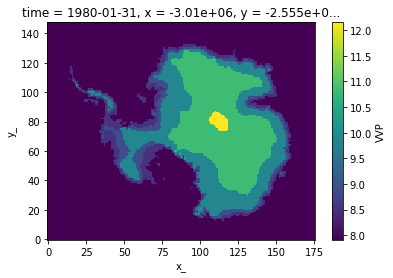

In [36]:
masked.isel(x = 0, y=0).VVP.plot(y='y_')

In [36]:
def findLastNonNan(y0, x0, time0, f0, VAR):        
    d = pd.DataFrame(f0.sel(time=time0, y=y0)[VAR].values) # shape (plvel, x)
    d.columns = f0.x.values
    
    lastInd = d[x0].last_valid_index()
    lastNonNanValue = f0.sel(y=y0, x=x0, time =time0).isel(PLEV=lastInd)[VAR].values
    
    return lastInd, lastNonNanValue

def findLastNonNanTimeOld(time0, f0, VAR, f0shape):
    a = np.empty((f0.dims['y'],f0.dims['x'])) # shape (y,x)
    b = np.empty((f0.dims['y'],f0.dims['x']))  # shape (y,x)

    # For each (y,x) position look for last non nan plevel
    for ynumb, xnumb in np.ndindex(f0shape):
        y0 = f0.y[ynumb].values
        x0 = f0.x[xnumb].values
        
        lastInd, lastNonNanValue = findLastNonNan(y0, x0, time0, f0, VAR)

        # add index of last non nan value
        a[ynumb, xnumb] = lastInd
        # add last non nan value
        b[ynumb, xnumb] = lastNonNanValue  
    return a, b

def findLastNonNanTimeParallel(time0, f0, VAR, f0shape):
    # Step 1: Init multiprocessing.Pool()
    pool = mp.Pool(8)
    
    a = np.empty((f0.dims['y'],f0.dims['x'])) # shape (y,x)
    b = np.empty((f0.dims['y'],f0.dims['x']))  # shape (y,x)
    
    # For each (y,x) position look for last non nan plevel
    for ynumb, xnumb in np.ndindex(f0shape):
        # Step 2: `pool.apply` the `findLastNonNan()`
        lastInd, lastNonNanValue = pool.apply(findLastNonNan, args=(ynumb, xnumb, time0, f0, VAR))

        # add last non nan value
        a[ynumb,xnumb] = lastInd
        b[ynumb, xnumb] = lastNonNanValue  
    
    # Step 3: Don't forget to close
    pool.close()   
    return a, b

In [37]:
def PreProcWinds(f0):
    A, B = [], []

    # For each time step t get a matrix of shape (plev, y, x)
    # For each value of y (rownmb) and x (colnmb) want to find plev that is the last non nan value
    #Time = len(f0.time) # all time steps 
    Time = 1
    
    y = f0.dims['y']
    x = f0.dims['x']
    f0shape = (y,x) # shape (y,x) of matrix

    for j in tqdm(range(Time)): # for each time step
        time0 = f0.time[j].values # time-step
        
        #a, b = findLastNonNanTime(time0, f0, VAR, f0shape)
        
        a, b = findLastNonNanTimeParallel(time0, f0, VAR, f0shape)

        A.append(a)
        B.append(b)
    
    d = xr.Dataset(coords = f0.coords, attrs = f0.attrs)
    d['VVP'] = xr.Variable(dims = ('time','y','x'), 
                                data = B, 
                                attrs = f0['VVP'].attrs)
    return d

In [38]:
%%time
y = f0.dims['y']
x = f0.dims['x']
f0shape = (y,x)

time0 = f0.time[0].values # time-step
a, b = findLastNonNanTime(time0, f0, VAR, f0shape)

CPU times: user 38.8 s, sys: 3.15 ms, total: 38.9 s
Wall time: 38.9 s


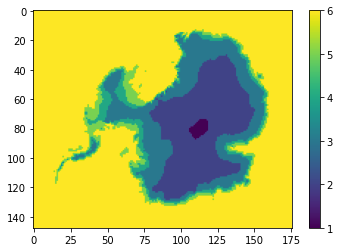

In [39]:
plt.imshow(a)
plt.colorbar()

In [ ]:
%%time

PreProcWinds(f0)

In [ ]:
vars_= ['VVP', 'UUP']
! rm -r ../../data/tmp/*

download = True
if download:
    for VAR in vars_:
        print(f'{VAR}:\n--------------')
        pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/{VAR}/'
        pathLocal = '../../data/tmp/'
        filesGC = listFilesGC(pathGC, VAR)

        #------ Download files from GC
        print('Downloading files from GC')
        downloadFilesFromGC(pathGC, pathLocal, filesGC)

        onlyfiles = filesInDirWithVar(pathLocal, VAR)
        print('Examples of files: \n {}'.format(onlyfiles[0]))

        #------ concatenate all years of a variable
        # first year
        if len(onlyfiles) == 121:
            print('Concatenating...')
            f0 = xr.open_dataset(pathLocal+onlyfiles[0])
            # preprocessing and resampling
            f0 = resampleMonthlyMean(BasicPreprocRCM(ProcessRCMVar(VAR, f0)))
            df0 = PreProcWinds(f0)
            for f in onlyfiles[1:]:
                f0 = xr.open_dataset(pathLocal+f)
                # preprocessing and resampling
                f0 = resampleMonthlyMean(BasicPreprocRCM(ProcessRCMVar(VAR, f0)))
                
                df = PreProcWinds(f0)
        
                # concatenate with previous years
                df0 = xr.concat([df0,df], dim = 'time')

            # save file locally:
            path = '../../data/toGC/'
            name = f'{VAR}_ant-35km_ACCESS1.3_rcp8.5_r1i1p1_ULg-MAR311_v1_monthly_spwinds.nc'
            df0.to_netcdf(name)

            # upload to GC:
            print('Uploading to GC...')
            pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/monthly/'
            uploadFileToGC(pathGC, name)

            # delete file and temporary directory:
            os.remove(name)
            ! rm ../../data/tmp/*

        else:
            print(f'Error: len only files is:{len(onlyfiles)}')
            break

In [ ]:
d = PreProcWinds(f0)
# plot last image to see if makes sense
plt.imshow(A[0])
plt.colorbar()

In [ ]:
"""
from multiprocessing import Pool

def findLastNonNan(ynumb, xnumb):
    y0 = f0.y[ynumb].values
    x0 = f0.x[xnumb].values
        
    d = pd.DataFrame(f0.sel(time=time0, y=y0)[VAR].values) # shape (plvel, x)
    lastInd = d[xnumb].last_valid_index()
    lastNonNanValue = f0.sel(y=y0, x=x0, time =time0).isel(PLEV=lastInd)[VAR].values
    
    return lastInd, lastNonNanValue

A, B = [], []

# For each time step t get a matrix of shape (plev, y, x)
# For each value of y (rownmb) and x (colnmb) want to find plev that is the last non nan value

Time = len(f0.time) # all time steps 

y = f0.dims['y']
x = f0.dims['x']
f0shape = (y,x) # shape (y,x) of matrix

for j in tqdm(range(Time)): # for each time step
    time0 = f0.time[j].values # time-step
    
    a  = np.empty((f0.dims['y'],f0.dims['x'])) # shape (y,x)
    b = np.empty((f0.dims['y'],f0.dims['x']))  # shape (y,x)
    
    
    pool = Pool()                         # Create a multiprocessing Pool
    
    coordinates_ = np.ndindex(f0shape)
    pool.map(findLastNonNan, coordinates_)
    
    # For each (y,x) position look for last non nan plevel
    for ynumb, xnumb in np.ndindex(f0shape):
        lastInd, lastNonNanValue = findLastNonNan(ynumb, xnumb)
        
        # add index of last non nan value
        a[ynumb,xnumb] = lastInd
        # add last non nan value
        b[ynumb,xnumb] = lastNonNanValue
    
    A.append(a)
    B.append(b)
    
# plot last image to see if makes sense
plt.imshow(a)
plt.colorbar()"""